### A starting notebook for the Poisson solver

In this package we seek to solve the Poisson equation on a rectangular domain

In [1]:
using Pkg
Pkg.activate("/Users/jeff/Dropbox/MAE250H/julia/development/project1")

"/Users/jeff/Dropbox/MAE250H/julia/development/project1/Project.toml"

The usual set of notebooks

In [2]:
using Revise
using Plots
using LinearAlgebra
using FFTW
using project1

┌ Info: Recompiling stale cache file /Users/jeff/.julia/compiled/v1.1/project1/iNSuZ.ji for project1 [69e8fe16-69bc-11e9-02db-a52d5bc2d713]
└ @ Base loading.jl:1184


### Set up the physical problem

In [3]:
LX = 1  # length of x side
x0, y0 = 0.0, 0.0  # coordinates of lower left hand corner of domain

(0.0, 0.0)

#### Set boundary conditions of the problem

In [4]:
uL(y,t) = 0.0
uR(y,t) = 0.0
uB(x,t) = 0.0
uT(x,t) = 1*sin(π*x)

uT (generic function with 1 method)

### Now numerical parameters

In [5]:
NX = 64
NY = 64

64

In [6]:
Δx = LX/NX

0.015625

Pack the parameters into a Parameters type

In [7]:
?ScalarDirichletParameters

search: ScalarDirichletParameters



```
ScalarDirichletParameters(Δx,x0,y0,uL,uR,uB,uT)
```

Set the problem parameters for a scalar-valued problem with Dirichlet boundary conditions


In [8]:
params = ScalarDirichletParameters(Δx,x0,y0,uL,uR,uB,uT)

ScalarDirichletParameters(0.015625, 0.0, 0.0, uL, uR, uB, uT)

### Solve a Dirichlet Poisson problem with Gauss-Seidel

Apply boundary conditions to the solution vector and move these into the RHS

In [19]:
# The solution vector
u = CellData(NX,NY)

# The RHS vector
f = CellData(u);

In [20]:
apply_bc!(u,0,params)
f̃ = Δx^2*f - laplacian(u);

In [21]:
tol = 1e-8

1.0e-8

Set parameters for the G-S scheme

In [22]:
gsparams = RelaxationParameters(apply_dirichlet_bc!,1,"GS")

RelaxationParameters(project1.apply_dirichlet_bc!, 1, "GS")

Now solve

In [23]:
resid_norm = norm(f - laplacian(u))
iter = 0
@time while resid_norm > tol
    global resid_norm = smooth!(u,f̃,gsparams)    
    global iter += 1
end
apply_bc!(u,0,params);
println("Number of iterations = ",iter)
println("Residual norm = ",resid_norm)

  0.366819 seconds (111.88 k allocations: 629.385 MiB, 15.47% gc time)
Number of iterations = 4683
Residual norm = 9.984703472227842e-9


In [24]:
uexact = CellData(u)
ic = indices(uexact,1,interior=false)
jc = indices(uexact,2,interior=false)

for j in jc, i in ic
    x, y = xmap(i,uexact,params),ymap(j,uexact,params)

    uexact[i,j] = sin(π*x)*sinh(π*y)/sinh(π)
end

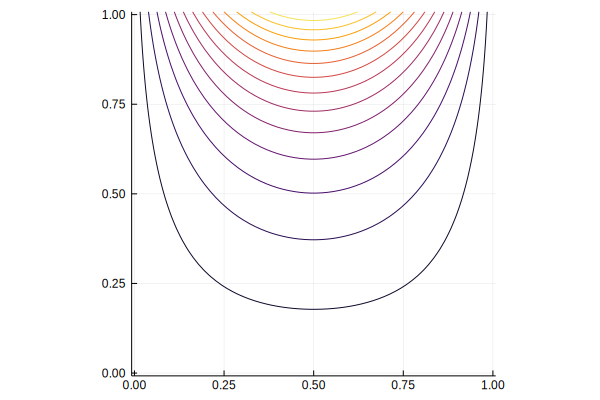

In [25]:
ic = indices(u,1,interior=false)
jc = indices(u,2,interior=false)
contour(xmap(ic,u,params),ymap(jc,u,params),transpose(u[ic,jc]),legend=false,ratio=1)

In [27]:
norm(u-uexact)/norm(uexact)

1.0

### Solve with multigrid

Apply boundary conditions to the solution vector and move these into the RHS

In [79]:
# The solution vector
u = CellData(NX,NY)

# The RHS vector
f = CellData(u);

In [80]:
apply_bc!(u,0,params)
f̃ = Δx^2*f - laplacian(u)
fill!(u,0.0);

In [81]:
?MGParameters

search: MGParameters



```
MGParameters
```

Set parameters for multigrid solution.

# Constructors

  * `MGParameters(apply_bc!,niteri,niter1,niter2,niterf,maxlev,gstol,gsmaxiter,maxcycle,tol)`


In [82]:
maxlev = floor(log2(NX))
mgparams = MGParameters(apply_dirichlet_bc!,1,1,1,1,maxlev,1e-14,10000,1000,1e-7)

MGParameters(project1.apply_dirichlet_bc!, 1, 1, 1, 1, 6, 1.0e-14, 10000, 1000, 1.0e-7)

In [132]:
function test_grid(u::ScalarData{NX,NY}) where {NX,NY}
    return eval(nameof(typeof(u)))(5,5)
end

test_grid (generic function with 1 method)

In [133]:
test_grid(u)

7×7 CellData{5,5}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [83]:
?mg!

search: mg! merge! mgcycle!



```
mg!(u::CellData,f::CellData,p::MGParameters) -> Float64
```

Uses multigrid to solve the Poisson system Lu = f, with the right-hand side `f` and initial guess `u`, and multigrid parameters provided in `p`. The function returns the final solution `u` in place. It also returns the final residual norm.


In [84]:
@time resid_norm = mg!(u,f̃,mgparams)
println("Residual norm = ",resid_norm)
apply_bc!(u,0.0,params);

Number of iterations = 147
  0.055501 seconds (137.02 k allocations: 69.399 MiB, 22.45% gc time)
Residual norm = 9.496567211171152e-8


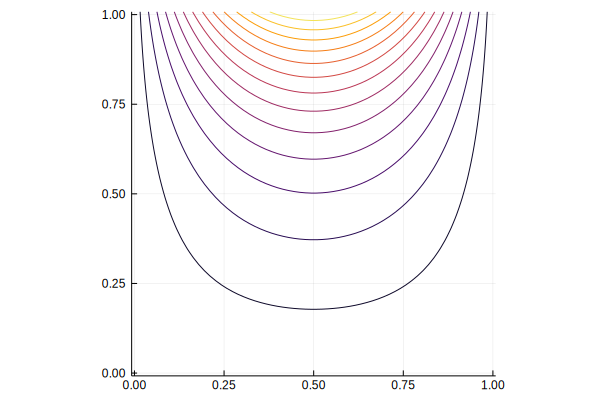

In [85]:
ic = indices(u,1,interior=false)
jc = indices(u,2,interior=false)
contour(xmap(ic,u,params),ymap(jc,u,params),transpose(u[ic,jc]),legend=false,ratio=1)

In [86]:
norm(u-uexact)/norm(uexact)

11.06604926593045

### Now solve a Neumann problem with multigrid

In [67]:
# The solution vector
u = CellData(NX,NY)

P = 3
Q = 2

f = CellData(u)
uexact = CellData(u)
ic = indices(f,1,interior=false)
jc = indices(f,2,interior=false)

for j in jc, i in ic
    x, y = xmap(i,uexact,params),ymap(j,uexact,params)

    f[i,j] = cos(P*π*x)*cos(Q*π*y)
    uexact[i,j] = cos(P*π*x)*cos(Q*π*y)
end
uexact .= -f/π^2/(P^2+Q^2);

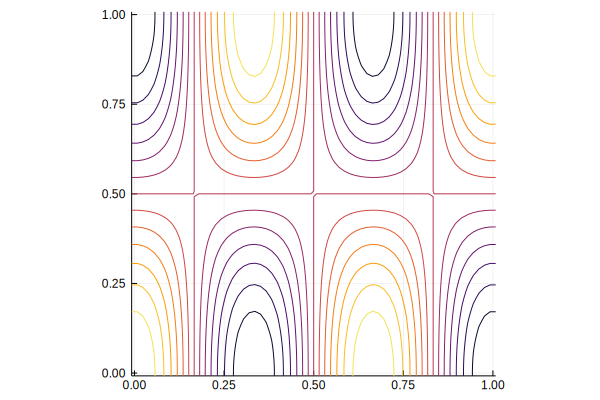

In [49]:
contour(xmap(ic,u,params),ymap(jc,u,params),transpose(f[ic,jc]),legend=false,ratio=1)

In [16]:
u = CellData(NX,NY)
apply_neumann_bc!(u)
f̃ = Δx^2*f - laplacian(u)
fill!(u,0.0);

In [17]:
maxlev = floor(log2(NX))
mgparams = MGParameters(apply_neumann_bc!,1,1,1,1,maxlev,1e-6,10000,1000,1e-7)

MGParameters(project1.apply_neumann_bc!, 1, 1, 1, 1, 6, 1.0e-6, 10000, 1000, 1.0e-7)

In [18]:
@time resid_norm = mg!(u,f̃,mgparams)
println("Residual norm = ",resid_norm)
apply_neumann_bc!(u);

  0.044908 seconds (33.79 k allocations: 45.403 MiB, 29.53% gc time)
Residual norm = 9.837111290252742e-8


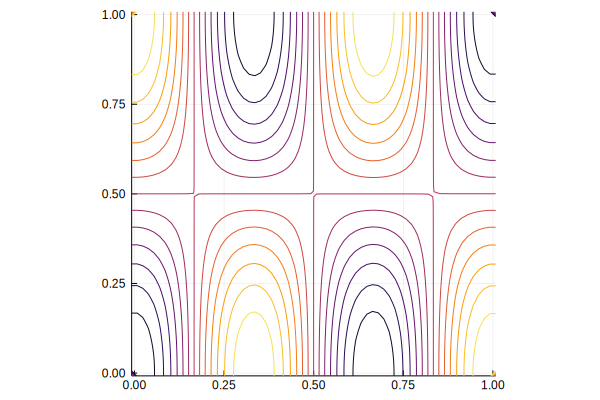

In [19]:
contour(xmap(ic,u,params),ymap(jc,u,params),transpose(u[ic,jc]),legend=false,ratio=1)

In [20]:
norm(u-uexact)/norm(uexact)

0.004987978028481853

### Now Neumann using discrete cosine transform

In [ ]:
u = CellData(NX,NY)
apply_neumann_bc!(u)
f̃ = Δx^2*f - laplacian(u)
u .= f̃
@time poisson_neumann_fft!(u)
norm(u-uexact)/norm(uexact)

### Solve a Dirichlet problem on nodes

In [12]:
uL(y,t) = 0.0
uR(y,t) = 0.0
uB(x,t) = 0.0
uT(x,t) = 0.0
params = ScalarDirichletParameters(Δx,x0,y0,uL,uR,uB,uT)

ScalarDirichletParameters(0.015625, 0.0, 0.0, uL, uR, uB, uT)

In [19]:
# The solution vector
u = NodeData(NX,NY)

P = 3
Q = 1

f = NodeData(u)
uexact = NodeData(u)
i_n = indices(f,1,interior=false)
j_n = indices(f,2,interior=false)

for j in j_n, i in i_n
    x, y = xmap(i,uexact,params),ymap(j,uexact,params)

    f[i,j] = sin(P*π*x)*sin(Q*π*y)
end
uexact .= -f/π^2/(P^2+Q^2);

In [20]:
apply_dirichlet_bc!(u)
f̃ = Δx^2*f - laplacian(u)
fill!(u,0.0);

In [21]:
maxlev = floor(log2(NX))
mgparams = MGParameters(apply_dirichlet_bc!,1,1,1,1,maxlev,1e-6,10000,1000,1e-7)

MGParameters(project1.apply_dirichlet_bc!, 1, 1, 1, 1, 6, 1.0e-6, 10000, 1000, 1.0e-7)

In [22]:
@time resid_norm = mg!(u,f̃,mgparams)
println("Residual norm = ",resid_norm)
apply_dirichlet_bc!(u);

  0.014448 seconds (10.19 k allocations: 15.044 MiB, 40.23% gc time)
Residual norm = 9.81125700065815e-8


In [23]:
norm(u-uexact)/norm(uexact)

0.002346512577573059